# Machine Learning Project — Lab-Style Redo (Movies)

**Course:** Machine Learning  
**Section:** ____________________

**Team Members:**
- Mohamed Mostafa : 23101594
- Marwan Khaled : 23101599
- Mohamed Adel : 23101899

**Dataset:** `Top_10000_Movies.csv`


In [1]:
# 0) Imports & settings
import os
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

RANDOM_STATE = 42

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


## 1) Load CSV into a DataFrame


In [3]:
# Load CSV (handle possible filename casing) + robust parsing fallbacks
import csv

workspace_dir = Path.cwd()

candidates = [
    workspace_dir / "Top_10000_Movies.csv",
    workspace_dir / "top_10000_movies.csv",
    workspace_dir / "TOP_10000_MOVIES.csv",
]

csv_path = next((p for p in candidates if p.exists()), None)
if csv_path is None:
    raise FileNotFoundError(
        "Could not find Top_10000_Movies.csv in the working directory. "
        "Expected one of: " + ", ".join(str(p.name) for p in candidates)
    )

print("Using dataset:", csv_path)

read_attempts = [
    ("default C-engine", dict()),
    ("python-engine", dict(engine="python")),
    (
        "python-engine (skip bad lines)",
        dict(engine="python", on_bad_lines="skip", encoding_errors="replace"),
    ),
    (
        "python-engine (sniff sep + skip bad lines)",
        dict(engine="python", sep=None, on_bad_lines="skip", encoding_errors="replace"),
    ),
    (
        "python-engine (QUOTE_NONE)",
        dict(
            engine="python",
            on_bad_lines="skip",
            encoding_errors="replace",
            quoting=csv.QUOTE_NONE,
            escapechar="\\",
        ),
    ),
]

last_err = None
for label, kwargs in read_attempts:
    try:
        df = pd.read_csv(csv_path, **kwargs)
        print(f"Read OK using: {label}")
        break
    except Exception as e:
        last_err = e
        print(f"Read failed using: {label} -> {type(e).__name__}: {e}")
else:
    raise last_err

df.head()

Using dataset: c:\college CSE\3RD LEVEL\3RD LEVEL SEM 1\machine learning\ML project\Top_10000_Movies.csv
Read failed using: default C-engine -> ParserError: Error tokenizing data. C error: Buffer overflow caught - possible malformed input file.

Read OK using: python-engine


,Unnamed: 0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
0,0,580489.0,en,Venom: Let There Be Carnage,5401.308,2021-09-30,6.8,1736.0,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,424000000.0,97.0,NaN
1,1,524434.0,en,Eternals,3365.535,2021-11-03,7.1,622.0,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,165000000.0,157.0,In the beginning...
2,2,438631.0,en,Dune,2911.423,2021-09-15,8.0,3632.0,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...",331116356.0,155.0,"Beyond fear, destiny awaits."
3,3,796499.0,en,Army of Thieves,2552.437,2021-10-27,6.9,555.0,"['Action', 'Crime', 'Thriller']",A mysterious woman recruits bank teller Ludwig...,0.0,127.0,"Before Vegas, one locksmith became a legend."
4,4,550988.0,en,Free Guy,1850.470,2021-08-11,7.8,3493.0,"['Comedy', 'Action', 'Adventure', 'Science Fic...",A bank teller called Guy realizes he is a back...,331096766.0,115.0,Life's too short to be a background character.


## 2) Quick Data Audit (shape, columns, dtypes, missingness)


Shape: (10002, 14)

Columns:
['unnamed_0', 'id', 'original_language', 'original_title', 'popularity', 'release_date', 'vote_average', 'vote_count', 'genre', 'overview', 'revenue', 'runtime', 'tagline', 'release_year']

Dtypes:


unnamed_0            string[python]
id                          float64
original_language    string[python]
original_title       string[python]
popularity                  float64
release_date         datetime64[ns]
vote_average                float64
vote_count                  float64
genre                string[python]
overview             string[python]
revenue                     float64
runtime                     float64
tagline              string[python]
release_year                float64
dtype: object


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 10002 entries, 0 to 10013
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   unnamed_0          10002 non-null  string        
 1   id                 10001 non-null  float64       
 2   original_language  10001 non-null  string        
 3   original_title     10000 non-null  string        
 4   popularity         10000 non-null  float64       
 5   release_date       9962 non-null   datetime64[ns]
 6   vote_average       10000 non-null  float64       
 7   vote_count         10000 non-null  float64       
 8   genre              10000 non-null  string        
 9   overview           9900 non-null   string        
 10  revenue            9998 non-null   float64       
 11  runtime            9989 non-null   float64       
 12  tagline            7079 non-null   string        
 13  release_year       9962 non-null   float64       
dtypes: d

None


Describe (include='all'):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
unnamed_0,10002,10002,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,10001.0,NaN,NaN,NaN,250028.080492,0.0,11866.0,144336.0,451480.0,893478.0,261733.475017
original_language,10001,48,en,7798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,10000,9756,Polaroid,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,10000.0,NaN,NaN,NaN,34.516871,6.269,11.908,17.488,29.62625,5401.308,100.693958
release_date,9962,NaN,NaN,NaN,2008-01-19 08:18:07.010640640,1902-04-17 00:00:00,2002-11-29 06:00:00,2012-11-09 00:00:00,2018-03-08 00:00:00,2028-12-20 00:00:00,NaN
vote_average,10000.0,NaN,NaN,NaN,6.29875,0.0,5.9,6.5,7.1,9.5,1.43426
vote_count,10000.0,NaN,NaN,NaN,1315.0849,0.0,118.0,425.5,1297.25,30184.0,2501.899103
genre,10000,2314,['Drama'],533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,9900,9895,Plot unknown.,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Top missing columns:


,missing,missing_%
tagline,2923,29.22
overview,102,1.02
release_date,40,0.40
release_year,40,0.40
runtime,13,0.13
revenue,4,0.04
original_title,2,0.02
genre,2,0.02
vote_average,2,0.02
popularity,2,0.02


Saved: labstyle_artifacts\figures\bar_missingness_top25.png


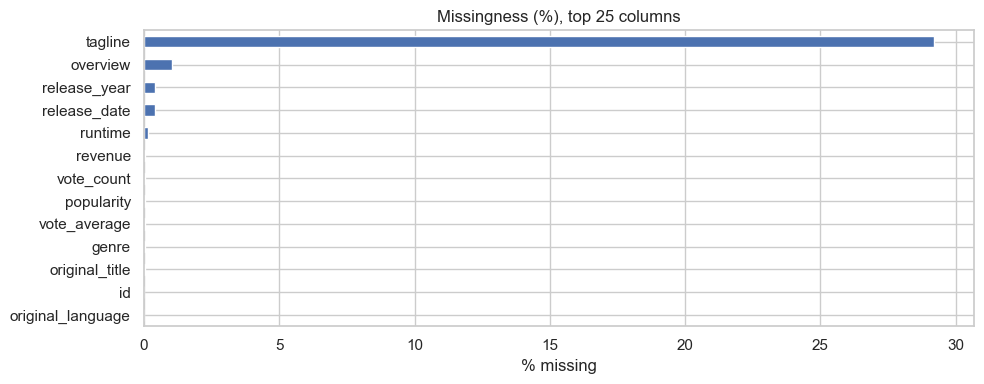

In [18]:
print("Shape:", df.shape)
print("\nColumns:")
print(list(df.columns))

print("\nDtypes:")
display(df.dtypes)

print("\nInfo:")
display(df.info())

print("\nDescribe (include='all'):")
display(df.describe(include="all").T.head(30))

# Missing values
missing = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({"missing": missing, "missing_%": missing_pct})

print("\nTop missing columns:")
display(missing_df.head(30))

plt.figure(figsize=(10, 4))
(missing_pct[missing_pct > 0].head(25)).sort_values().plot(kind="barh")
plt.title("Missingness (%), top 25 columns")
plt.xlabel("% missing")
plt.tight_layout()

# Save plot early (even if save_fig isn't defined yet)
_artifacts_dir = globals().get("artifacts_dir", Path.cwd() / "labstyle_artifacts")
_figures_dir = globals().get("figures_dir", _artifacts_dir / "figures")
_figures_dir.mkdir(parents=True, exist_ok=True)
_out = _figures_dir / "bar_missingness_top25.png"
plt.savefig(_out, dpi=200, bbox_inches="tight")

# Track for PDF if FIGURE_PATHS exists (or create it)
if "FIGURE_PATHS" in globals():
    FIGURE_PATHS.append(_out)
else:
    FIGURE_PATHS = [_out]

print("Saved:", _out)
plt.show()


## 3) Data Cleaning & Type Casting

This section standardizes column names, cleans text fields, converts numeric-like columns, parses dates (if present), and removes duplicates to create `df_clean`.


In [5]:
import re


def to_snake_case(name: str) -> str:
    name = name.strip()
    name = re.sub(r"[\s\-\/]+", "_", name)
    name = re.sub(r"[^0-9a-zA-Z_]+", "", name)
    name = re.sub(r"_+", "_", name)
    return name.lower().strip("_")


def pick_column(df_: pd.DataFrame, candidates: list[str]) -> str | None:
    # Try exact match first
    for c in candidates:
        if c in df_.columns:
            return c
    # Try case-insensitive / snake-case match
    lowered = {to_snake_case(c): c for c in df_.columns}
    for c in candidates:
        key = to_snake_case(c)
        if key in lowered:
            return lowered[key]
    return None


df_raw = df.copy()

# Standardize column names
rename_map = {c: to_snake_case(str(c)) for c in df.columns}
df = df.rename(columns=rename_map)

# Strip whitespace in object columns
for c in df.select_dtypes(include=["object"]).columns:
    df[c] = df[c].astype("string").str.strip()

# Common column guesses (after snake_case)
col_title = pick_column(df, ["title", "movie_title", "original_title", "name"])
col_id = pick_column(df, ["id", "movie_id", "tmdb_id", "imdb_id"])
col_rating = pick_column(df, ["vote_average", "rating", "score", "imdb_rating", "average_rating"])
col_votes = pick_column(df, ["vote_count", "votes", "num_votes", "rating_count"])
col_revenue = pick_column(df, ["revenue", "box_office", "gross", "worldwide_gross"])
col_runtime = pick_column(df, ["runtime", "duration", "length", "minutes"])
col_year = pick_column(df, ["year", "release_year"])
col_release_date = pick_column(df, ["release_date", "date", "released", "premiere"])
col_genres = pick_column(df, ["genres", "genre", "genre_names"])
col_country = pick_column(df, ["country", "production_countries", "origin_country"])

print("Guessed columns:")
print({
    "title": col_title,
    "id": col_id,
    "rating": col_rating,
    "votes": col_votes,
    "revenue": col_revenue,
    "runtime": col_runtime,
    "year": col_year,
    "release_date": col_release_date,
    "genres": col_genres,
    "country": col_country,
})

# Convert numeric-like columns (best-effort)
possible_numeric = [c for c in [col_rating, col_votes, col_revenue, col_runtime, col_year] if c]
for c in possible_numeric:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Parse dates if present
if col_release_date and col_release_date in df.columns:
    df[col_release_date] = pd.to_datetime(df[col_release_date], errors="coerce", infer_datetime_format=True)
    # Create release_year if possible
    if "release_year" not in df.columns:
        df["release_year"] = df[col_release_date].dt.year
        col_year = "release_year"

# If year exists but release_year missing, normalize
if col_year and col_year in df.columns:
    df[col_year] = pd.to_numeric(df[col_year], errors="coerce")
    df[col_year] = df[col_year].where(df[col_year].between(1870, 2100))
    if col_year != "release_year" and "release_year" not in df.columns:
        df["release_year"] = df[col_year]
        col_year = "release_year"

# Deduplicate
before = len(df)
if col_id and col_id in df.columns:
    df = df.drop_duplicates(subset=[col_id])
elif col_title and col_year and col_title in df.columns and col_year in df.columns:
    df = df.drop_duplicates(subset=[col_title, col_year])
elif col_title and col_title in df.columns:
    df = df.drop_duplicates(subset=[col_title])
else:
    df = df.drop_duplicates()

after = len(df)
print(f"Dropped duplicates: {before - after} (from {before} to {after})")

# Create cleaned dataframe
# (We keep df as cleaned moving forward, but also expose df_clean for clarity)
df_clean = df.copy()

print("Cleaned shape:", df_clean.shape)
df_clean.head()

Guessed columns:
{'title': 'original_title', 'id': 'id', 'rating': 'vote_average', 'votes': 'vote_count', 'revenue': 'revenue', 'runtime': 'runtime', 'year': None, 'release_date': 'release_date', 'genres': 'genre', 'country': None}
Dropped duplicates: 12 (from 10014 to 10002)
Cleaned shape: (10002, 14)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_17740\1340418994.py:69: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df[col_release_date] = pd.to_datetime(df[col_release_date], errors="coerce", infer_datetime_format=True)


,unnamed_0,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline,release_year
0,0,580489.0,en,Venom: Let There Be Carnage,5401.308,2021-09-30,6.8,1736.0,"['Science Fiction', 'Action', 'Adventure']",After finding a host body in investigative rep...,424000000.0,97.0,<NA>,2021.0
1,1,524434.0,en,Eternals,3365.535,2021-11-03,7.1,622.0,"['Action', 'Adventure', 'Science Fiction', 'Fa...",The Eternals are a team of ancient aliens who ...,165000000.0,157.0,In the beginning...,2021.0
2,2,438631.0,en,Dune,2911.423,2021-09-15,8.0,3632.0,"['Action', 'Adventure', 'Science Fiction']","Paul Atreides, a brilliant and gifted young ma...",331116356.0,155.0,"Beyond fear, destiny awaits.",2021.0
3,3,796499.0,en,Army of Thieves,2552.437,2021-10-27,6.9,555.0,"['Action', 'Crime', 'Thriller']",A mysterious woman recruits bank teller Ludwig...,0.0,127.0,"Before Vegas, one locksmith became a legend.",2021.0
4,4,550988.0,en,Free Guy,1850.470,2021-08-11,7.8,3493.0,"['Comedy', 'Action', 'Adventure', 'Science Fic...",A bank teller called Guy realizes he is a back...,331096766.0,115.0,Life's too short to be a background character.,2021.0


## 4) Basic Descriptive Stats & Rankings

We’ll compute summary stats and show safe top-N rankings by rating, votes, and revenue (if available).


In [6]:
display(df_clean.describe(include="all").T.head(40))

# Helper: safe top-N sorting

def top_n(df_: pd.DataFrame, by: str, n: int = 10, tie_breaker: str | None = None, ascending: bool = False):
    cols = [c for c in [col_title, col_year, by, tie_breaker] if c and c in df_.columns]
    sub = df_[cols].copy()
    sort_cols = [by] + ([tie_breaker] if tie_breaker and tie_breaker in sub.columns else [])
    sub = sub.dropna(subset=[by])
    return sub.sort_values(sort_cols, ascending=[ascending] + ([False] if tie_breaker else [])).head(n)

print("Top by rating (if available):")
if col_rating:
    display(top_n(df_clean, col_rating, n=10, tie_breaker=col_votes))
else:
    print("No rating-like column detected.")

print("Top by votes (if available):")
if col_votes:
    display(top_n(df_clean, col_votes, n=10))
else:
    print("No votes-like column detected.")

print("Top by revenue (if available):")
if col_revenue:
    display(top_n(df_clean, col_revenue, n=10))
else:
    print("No revenue-like column detected.")


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
unnamed_0,10002,10002,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
id,10001.0,NaN,NaN,NaN,250028.080492,0.0,11866.0,144336.0,451480.0,893478.0,261733.475017
original_language,10001,48,en,7798,NaN,NaN,NaN,NaN,NaN,NaN,NaN
original_title,10000,9756,Polaroid,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
popularity,10000.0,NaN,NaN,NaN,34.516871,6.269,11.908,17.488,29.62625,5401.308,100.693958
release_date,9962,NaN,NaN,NaN,2008-01-19 08:18:07.010640640,1902-04-17 00:00:00,2002-11-29 06:00:00,2012-11-09 00:00:00,2018-03-08 00:00:00,2028-12-20 00:00:00,NaN
vote_average,10000.0,NaN,NaN,NaN,6.29875,0.0,5.9,6.5,7.1,9.5,1.43426
vote_count,10000.0,NaN,NaN,NaN,1315.0849,0.0,118.0,425.5,1297.25,30184.0,2501.899103
genre,10000,2314,['Drama'],533,NaN,NaN,NaN,NaN,NaN,NaN,NaN
overview,9900,9895,Plot unknown.,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Top by rating (if available):


,original_title,release_year,vote_average,vote_count
7057,Bob Esponja: Días de Cangreburgers,2016.0,9.5,4.0
5024,Ebola Zombies,2015.0,9.5,2.0
577,鬼滅の刃 兄妹の絆,2019.0,9.4,17.0
2136,Јужни Ветар 2: Убрзање,2021.0,9.3,4.0
6361,French Lolita,1998.0,9.3,2.0
5252,번 더 스테이지: 더 무비,2018.0,9.2,309.0
4849,Franco Escamilla: Por La Anécdota,2018.0,9.2,88.0
9786,Mr. Robot: Behind the Mask,2017.0,9.1,7.0
8034,Colegialas lesbianas y el placer de pervertir,1983.0,9.1,4.0
8063,Las tres muertes de Marisela Escobedo,2020.0,9.0,175.0


Top by votes (if available):


,original_title,release_year,vote_count
266,Inception,2010.0,30184.0
316,Interstellar,2014.0,26999.0
976,The Dark Knight,2008.0,26148.0
235,Deadpool,2016.0,25733.0
173,The Avengers,2012.0,25642.0
66,Avatar,2009.0,24280.0
1003,Guardians of the Galaxy,2014.0,23329.0
97,Avengers: Infinity War,2018.0,23027.0
1447,Fight Club,1999.0,22758.0
1183,Pulp Fiction,1994.0,22032.0


Top by revenue (if available):


,original_title,release_year,revenue
66,Avatar,2009.0,2.847246e+09
167,Avengers: Endgame,2019.0,2.797801e+09
489,Titanic,1997.0,2.187464e+09
1013,Star Wars: The Force Awakens,2015.0,2.068224e+09
97,Avengers: Infinity War,2018.0,2.046240e+09
653,Jurassic World,2015.0,1.671713e+09
545,The Lion King,2019.0,1.667635e+09
173,The Avengers,2012.0,1.518816e+09
590,Furious 7,2015.0,1.515048e+09
230,Frozen II,2019.0,1.450027e+09


## 5) EDA: Distributions (ratings, votes, revenue, runtime)

We’ll plot distributions using log-scale for heavy-tailed variables (votes/revenue).


Saved: labstyle_artifacts\figures\hist_rating.png


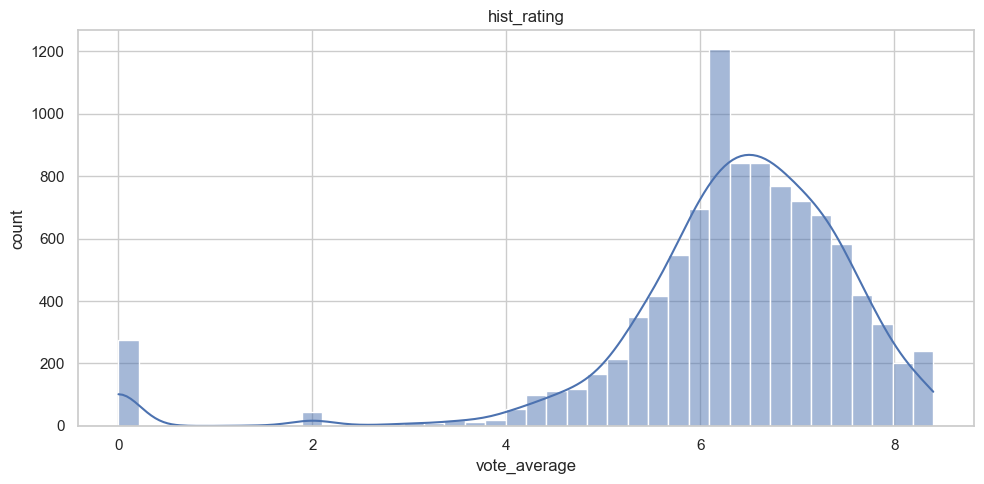

Saved: labstyle_artifacts\figures\hist_votes_log.png


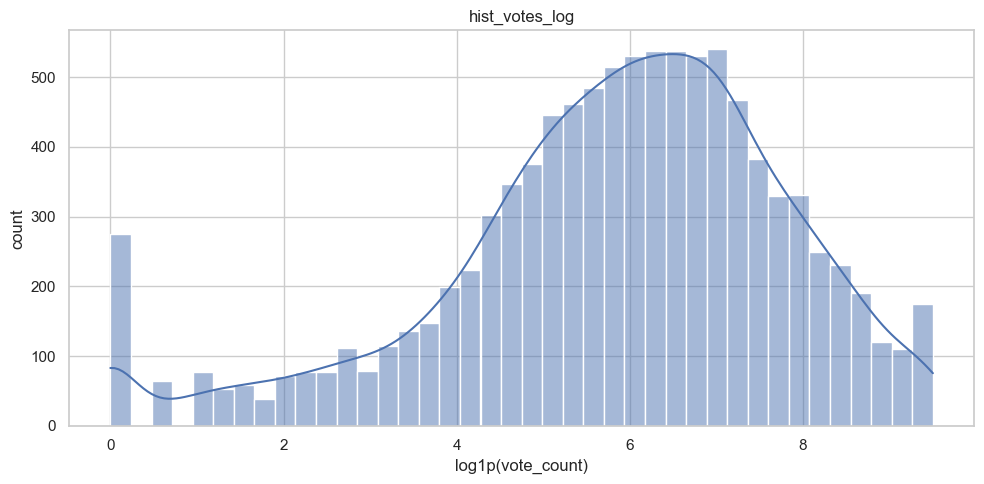

Saved: labstyle_artifacts\figures\hist_revenue_log.png


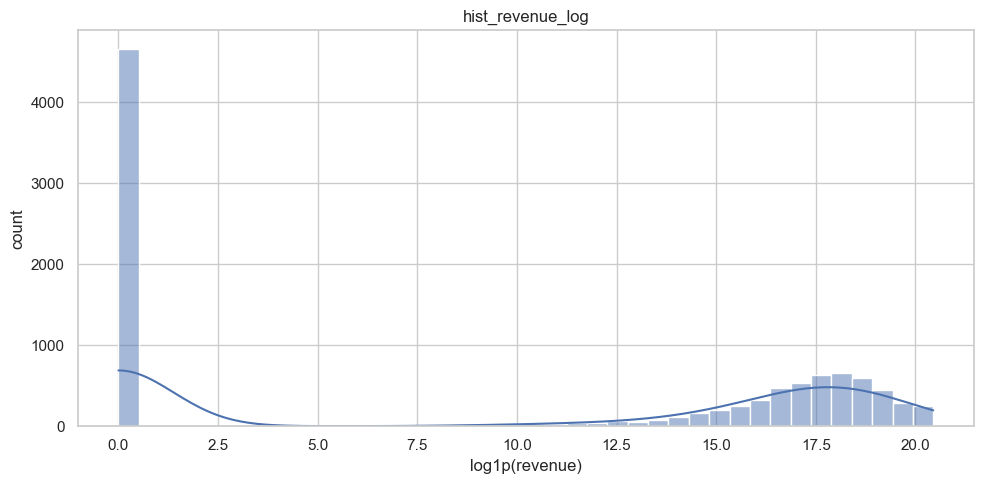

Saved: labstyle_artifacts\figures\hist_runtime.png


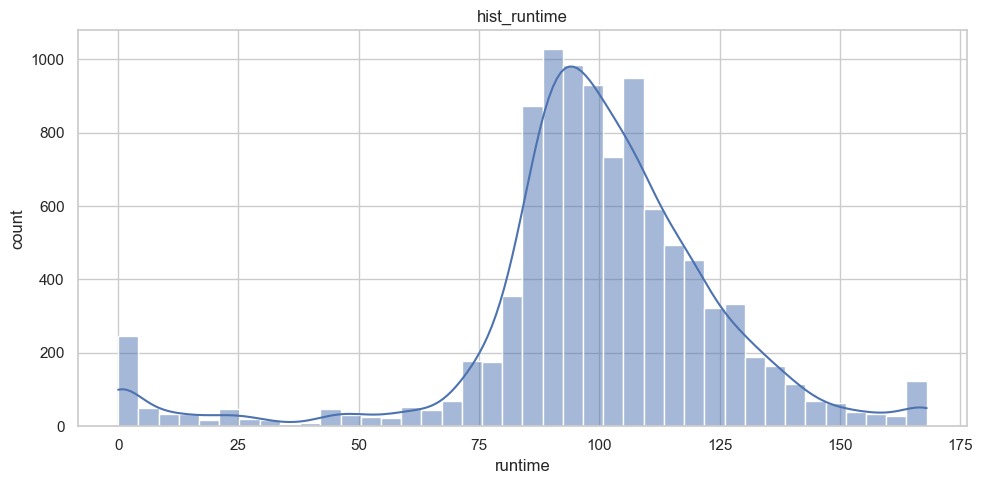

In [7]:
# Output folders + figure saving helpers
artifacts_dir = Path("labstyle_artifacts")
figures_dir = artifacts_dir / "figures"
artifacts_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)

FIGURE_PATHS: list[Path] = []

def save_fig(name: str):
    safe = re.sub(r"[^0-9a-zA-Z_\-]+", "_", name).strip("_")
    path = figures_dir / f"{safe}.png"
    plt.tight_layout()
    plt.savefig(path, dpi=200, bbox_inches="tight")
    FIGURE_PATHS.append(path)
    print("Saved:", path)


def clip_series(s: pd.Series, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.Series:
    if s.dropna().empty:
        return s
    lo, hi = s.quantile(lower_q), s.quantile(upper_q)
    return s.clip(lo, hi)


def plot_hist(series: pd.Series, title: str, log1p: bool = False):
    s = series.dropna()
    if s.empty:
        print(f"Skip (no data): {title}")
        return
    s = clip_series(s)
    if log1p:
        s = np.log1p(s)
        xlabel = f"log1p({series.name})"
    else:
        xlabel = series.name

    plt.figure()
    sns.histplot(s, bins=40, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    save_fig(title)
    plt.show()

# Histograms (only if columns exist)
if col_rating:
    plot_hist(df_clean[col_rating], "hist_rating", log1p=False)

if col_votes:
    plot_hist(df_clean[col_votes], "hist_votes_log", log1p=True)

if col_revenue:
    plot_hist(df_clean[col_revenue], "hist_revenue_log", log1p=True)

if col_runtime:
    plot_hist(df_clean[col_runtime], "hist_runtime", log1p=False)


## 6) EDA: Relationships (correlations, scatterplots)


Saved: labstyle_artifacts\figures\correlation_heatmap.png


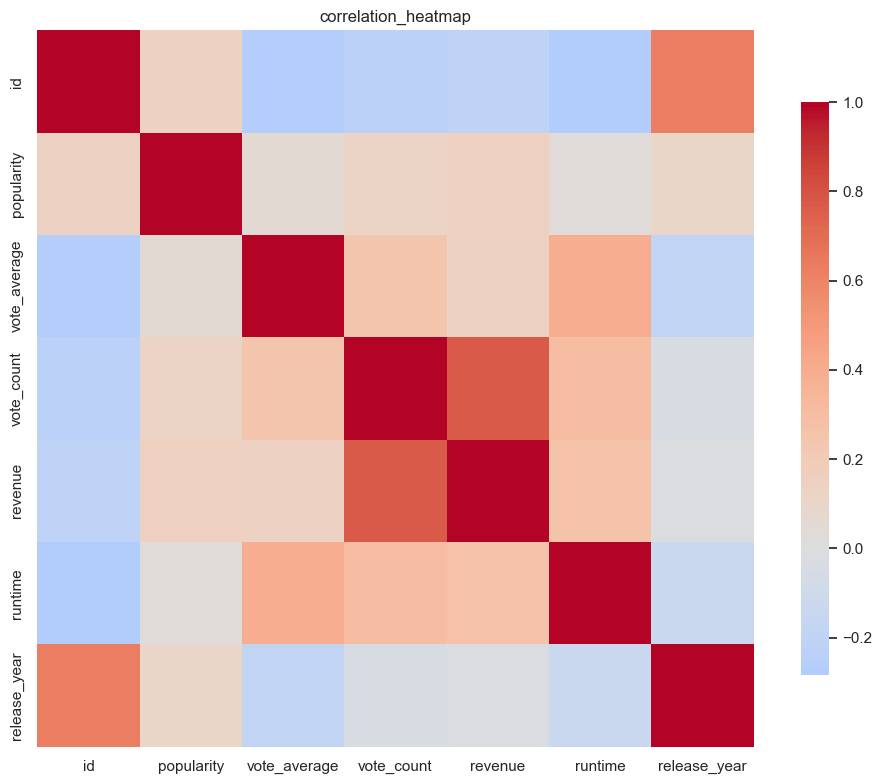

Saved: labstyle_artifacts\figures\scatter_rating_vs_log_votes.png


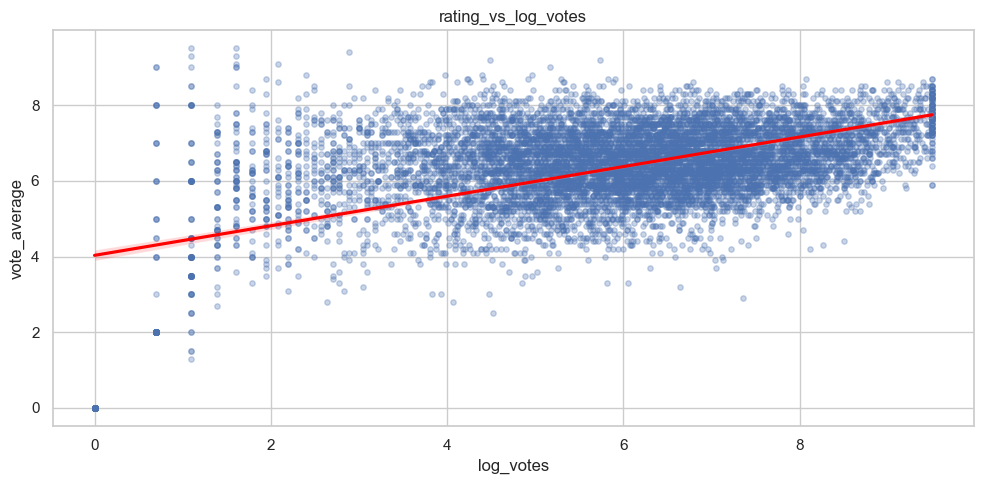

Saved: labstyle_artifacts\figures\scatter_log_revenue_vs_log_votes.png


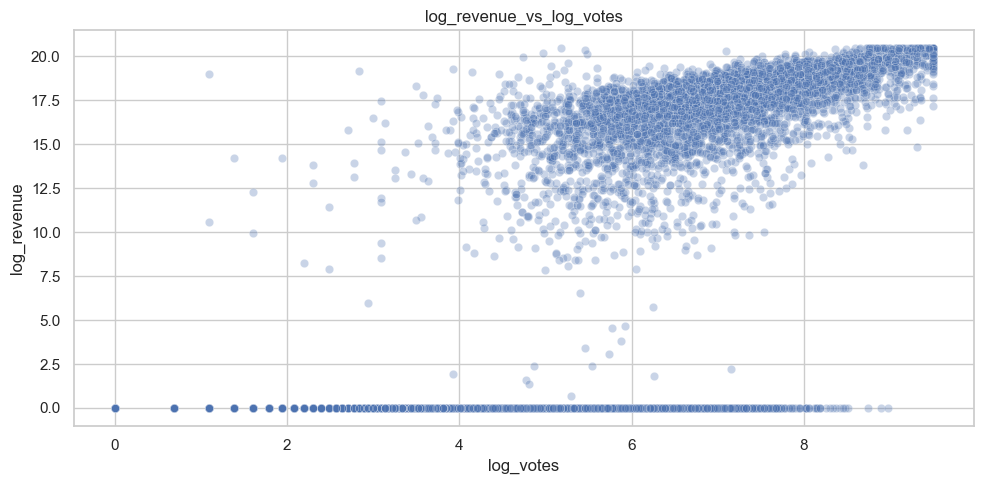

Saved: labstyle_artifacts\figures\scatter_rating_vs_runtime.png


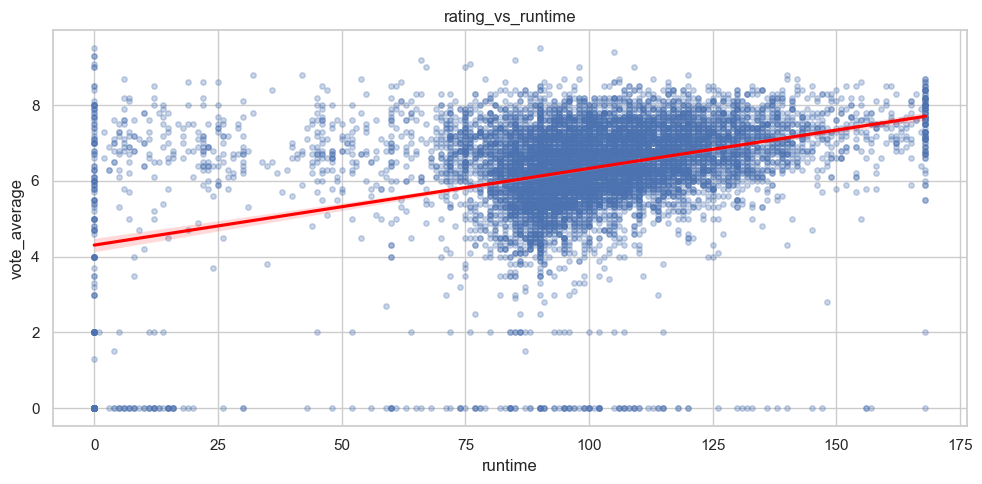

In [8]:
# Correlation heatmap (numeric)
num_df = df_clean.select_dtypes(include=[np.number]).copy()

if num_df.shape[1] >= 2:
    corr = num_df.corr(numeric_only=True)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
    plt.title("correlation_heatmap")
    save_fig("correlation_heatmap")
    plt.show()
else:
    print("Not enough numeric columns for correlation heatmap.")

# Scatterplots / relationships
if col_rating and col_votes:
    tmp = df_clean[[col_rating, col_votes]].dropna().copy()
    tmp[col_votes] = clip_series(tmp[col_votes])
    tmp["log_votes"] = np.log1p(tmp[col_votes])

    plt.figure()
    sns.regplot(data=tmp, x="log_votes", y=col_rating, scatter_kws={"alpha": 0.3, "s": 15}, line_kws={"color": "red"})
    plt.title("rating_vs_log_votes")
    save_fig("scatter_rating_vs_log_votes")
    plt.show()

if col_revenue and col_votes:
    tmp = df_clean[[col_revenue, col_votes]].dropna().copy()
    tmp[col_revenue] = clip_series(tmp[col_revenue])
    tmp[col_votes] = clip_series(tmp[col_votes])
    tmp["log_revenue"] = np.log1p(tmp[col_revenue])
    tmp["log_votes"] = np.log1p(tmp[col_votes])

    plt.figure()
    sns.scatterplot(data=tmp, x="log_votes", y="log_revenue", alpha=0.3)
    plt.title("log_revenue_vs_log_votes")
    save_fig("scatter_log_revenue_vs_log_votes")
    plt.show()

if col_runtime and col_rating:
    tmp = df_clean[[col_runtime, col_rating]].dropna().copy()
    tmp[col_runtime] = clip_series(tmp[col_runtime])

    plt.figure()
    sns.regplot(data=tmp, x=col_runtime, y=col_rating, scatter_kws={"alpha": 0.3, "s": 15}, line_kws={"color": "red"})
    plt.title("rating_vs_runtime")
    save_fig("scatter_rating_vs_runtime")
    plt.show()


## 7) Groupby Analysis (year/decade/genre/country)


Saved: labstyle_artifacts\figures\bar_movies_per_decade.png


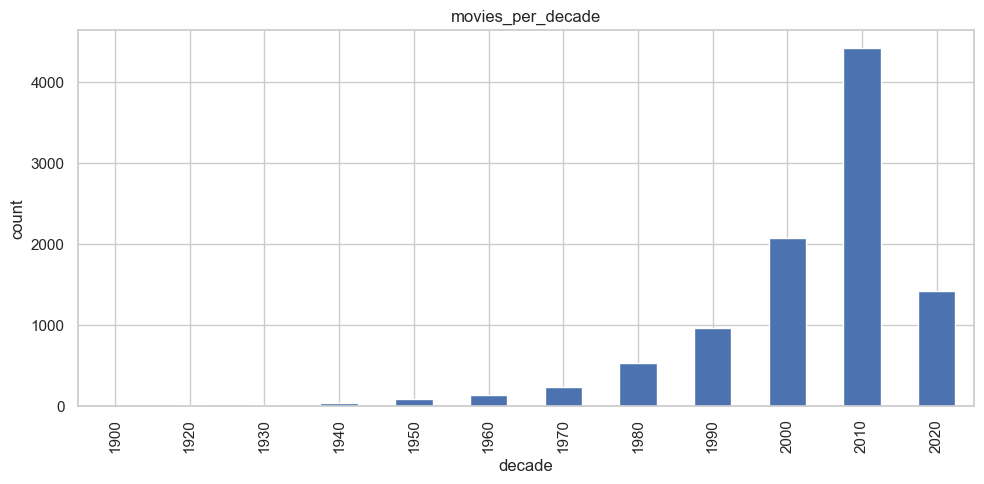

Saved: labstyle_artifacts\figures\line_avg_rating_by_decade.png


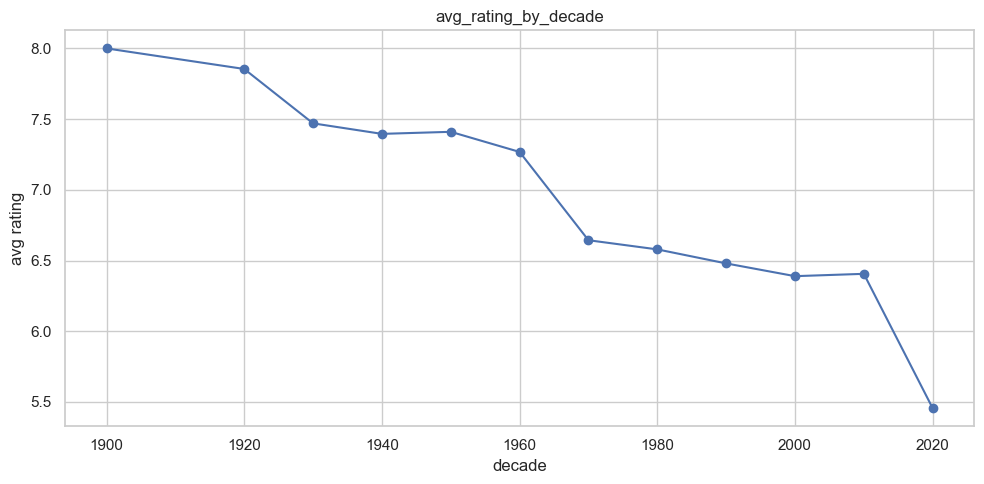

Saved: labstyle_artifacts\figures\bar_top_genres_by_count.png


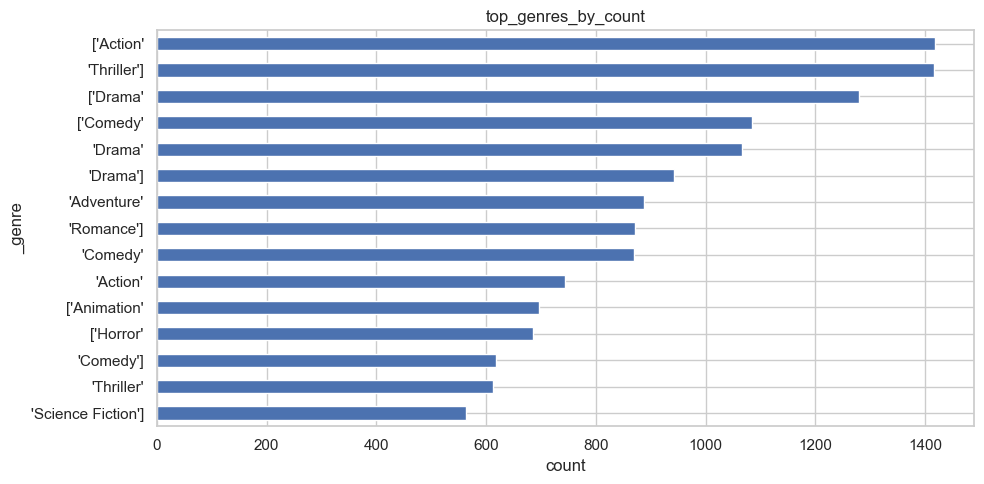

Saved: labstyle_artifacts\figures\bar_top_genres_by_avg_rating.png


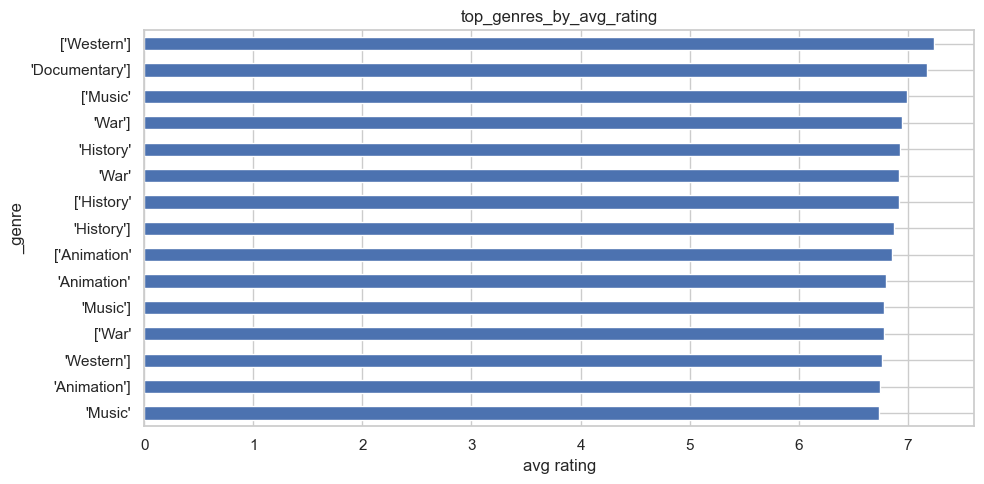

In [9]:
group_tables_dir = artifacts_dir / "tables"
group_tables_dir.mkdir(parents=True, exist_ok=True)

# Year/decade analysis
if col_year and col_year in df_clean.columns:
    tmp = df_clean.dropna(subset=[col_year]).copy()
    tmp["decade"] = (tmp[col_year] // 10 * 10).astype("Int64")

    decade_counts = tmp.groupby("decade").size().sort_index()
    plt.figure()
    decade_counts.plot(kind="bar")
    plt.title("movies_per_decade")
    plt.xlabel("decade")
    plt.ylabel("count")
    save_fig("bar_movies_per_decade")
    plt.show()

    if col_rating:
        decade_rating = tmp.groupby("decade")[col_rating].mean().sort_index()
        plt.figure()
        decade_rating.plot(kind="line", marker="o")
        plt.title("avg_rating_by_decade")
        plt.xlabel("decade")
        plt.ylabel("avg rating")
        save_fig("line_avg_rating_by_decade")
        plt.show()

# Genre analysis (if genres exists as delimited string)
if col_genres and col_genres in df_clean.columns:
    genres_series = df_clean[col_genres].dropna().astype("string")

    # Guess delimiter
    delimiter = "," if genres_series.str.contains(",").mean() > 0.2 else "|"
    exploded = (
        df_clean[[col_genres] + ([col_rating] if col_rating else [])]
        .dropna(subset=[col_genres])
        .assign(_genre=df_clean[col_genres].astype("string").str.split(delimiter))
        .explode("_genre")
    )
    exploded["_genre"] = exploded["_genre"].astype("string").str.strip()
    exploded = exploded[exploded["_genre"].ne("")]

    top_genres = exploded["_genre"].value_counts().head(15)
    plt.figure(figsize=(10, 5))
    top_genres.sort_values().plot(kind="barh")
    plt.title("top_genres_by_count")
    plt.xlabel("count")
    save_fig("bar_top_genres_by_count")
    plt.show()

    if col_rating:
        genre_rating = (
            exploded.groupby("_genre")[col_rating].mean().sort_values(ascending=False).head(15)
        )
        plt.figure(figsize=(10, 5))
        genre_rating.sort_values().plot(kind="barh")
        plt.title("top_genres_by_avg_rating")
        plt.xlabel("avg rating")
        save_fig("bar_top_genres_by_avg_rating")
        plt.show()

# Country analysis (basic)
if col_country and col_country in df_clean.columns:
    country_counts = df_clean[col_country].dropna().astype("string").value_counts().head(15)
    plt.figure(figsize=(10, 5))
    country_counts.sort_values().plot(kind="barh")
    plt.title("top_countries_by_count")
    plt.xlabel("count")
    save_fig("bar_top_countries_by_count")
    plt.show()

## 8) Top-N Queries & Custom Filters


In [12]:
def filter_movies(
    df_: pd.DataFrame,
    min_votes: int | None = None,
    year_min: int | None = None,
    year_max: int | None = None,
    genre_contains: str | None = None,
) -> pd.DataFrame:
    out = df_.copy()

    if min_votes is not None and col_votes and col_votes in out.columns:
        out = out[out[col_votes].fillna(0) >= min_votes]

    if (year_min is not None or year_max is not None) and col_year and col_year in out.columns:
        y = out[col_year]
        if year_min is not None:
            out = out[y >= year_min]
        if year_max is not None:
            out = out[y <= year_max]

    if genre_contains and col_genres and col_genres in out.columns:
        out = out[out[col_genres].astype("string").str.contains(genre_contains, case=False, na=False)]

    return out


def top_n_by(df_: pd.DataFrame, by: str, n: int = 10) -> pd.DataFrame:
    cols = [c for c in [col_title, col_year, by, col_rating, col_votes, col_revenue] if c and c in df_.columns]
    cols = list(dict.fromkeys(cols))  # preserve order, remove duplicates
    return df_[cols].dropna(subset=[by]).sort_values(by, ascending=False).head(n)


example = filter_movies(df_clean, min_votes=1000, year_min=2000)
print("Example filtered shape:", example.shape)

if col_rating:
    display(top_n_by(example, col_rating, n=10))
else:
    print("No rating-like column detected for top-N example.")


Example filtered shape: (2380, 14)


,original_title,release_year,vote_average,vote_count,revenue
234,君の名は。,2016.0,8.6,8013.0,3.579861e+08
976,The Dark Knight,2008.0,8.5,26148.0,1.004558e+09
563,기생충,2019.0,8.5,12445.0,2.575918e+08
533,The Lord of the Rings: The Return of the King,2003.0,8.5,18523.0,1.118889e+09
788,千と千尋の神隠し,2001.0,8.5,11996.0,2.749251e+08
1141,ハウルの動く城,2004.0,8.4,6789.0,2.360498e+08
367,映画 聲の形,2016.0,8.4,2614.0,3.015646e+07
316,Interstellar,2014.0,8.4,26999.0,7.017292e+08
1850,Whiplash,2014.0,8.4,11542.0,1.309200e+07
60,Zack Snyder's Justice League,2021.0,8.4,6803.0,6.570000e+08


## 9) Simple Scoring Model (Bayesian / Weighted Rating)

We reduce small-sample bias using:

$$WR = \frac{v}{v+m}R + \frac{m}{v+m}C$$

Where $R$ is the movie rating, $v$ is vote count, $C$ is global mean rating, and $m$ is a vote threshold (e.g., 60th percentile).


Global mean rating C=6.299, vote threshold m=667.4


,original_title,release_year,vote_average,vote_count,weighted_rating
1023,The Shawshank Redemption,1994.0,8.7,20048.0,8.622638
1103,The Godfather,1972.0,8.7,15020.0,8.597842
2069,Schindler's List,1993.0,8.6,11994.0,8.478698
976,The Dark Knight,2008.0,8.5,26148.0,8.445214
1812,The Godfather: Part II,1974.0,8.6,9028.0,8.441589
1183,Pulp Fiction,1994.0,8.5,22032.0,8.435280
1422,Forrest Gump,1994.0,8.5,21522.0,8.433792
533,The Lord of the Rings: The Return of the King,2003.0,8.5,18523.0,8.423445
234,君の名は。,2016.0,8.6,8013.0,8.423066
1267,The Green Mile,1999.0,8.5,12992.0,8.392447


Saved: labstyle_artifacts\tables\top_weighted_rating.csv
Saved: labstyle_artifacts\figures\scatter_weighted_vs_raw_rating.png


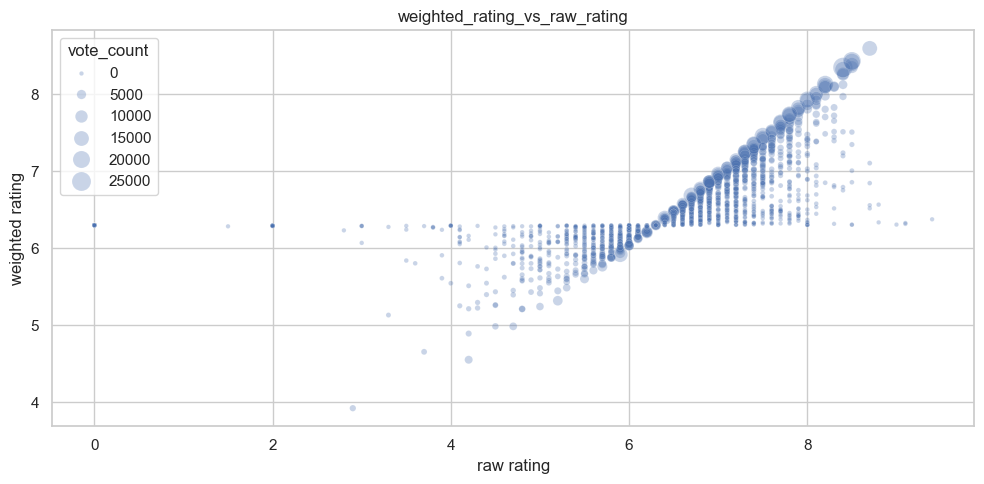

In [11]:
if not (col_rating and col_votes):
    print("Weighted rating requires both rating and votes columns. Skipping.")
else:
    scoring_df = df_clean[[c for c in [col_title, col_year, col_rating, col_votes] if c and c in df_clean.columns]].dropna(subset=[col_rating, col_votes]).copy()
    scoring_df[col_votes] = scoring_df[col_votes].fillna(0)

    C = scoring_df[col_rating].mean()
    m = scoring_df[col_votes].quantile(0.60)

    v = scoring_df[col_votes]
    R = scoring_df[col_rating]
    scoring_df["weighted_rating"] = (v / (v + m) * R) + (m / (v + m) * C)

    print(f"Global mean rating C={C:.3f}, vote threshold m={m:.1f}")

    top_wr = scoring_df.sort_values("weighted_rating", ascending=False).head(15)
    display(top_wr)

    # Save table
    out_path = group_tables_dir / "top_weighted_rating.csv"
    top_wr.to_csv(out_path, index=False)
    print("Saved:", out_path)

    # Plot comparison: raw rating vs weighted rating
    sample = scoring_df.sample(min(2000, len(scoring_df)), random_state=RANDOM_STATE)
    plt.figure()
    sns.scatterplot(data=sample, x=col_rating, y="weighted_rating", size=col_votes, sizes=(10, 200), alpha=0.3)
    plt.title("weighted_rating_vs_raw_rating")
    plt.xlabel("raw rating")
    plt.ylabel("weighted rating")
    save_fig("scatter_weighted_vs_raw_rating")
    plt.show()

## 10) Text Features (title keywords) & Search

We add a simple keyword search over the title column. Optionally, we build TF‑IDF title vectors and show nearest-neighbor title similarity.


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


def normalize_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"[^a-z0-9\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s


def search_titles(df_: pd.DataFrame, query: str, top_k: int = 10) -> pd.DataFrame:
    if not col_title or col_title not in df_.columns:
        raise ValueError("No title-like column detected.")

    q = normalize_text(query)
    tmp = df_[[c for c in [col_title, col_year, col_rating, col_votes] if c and c in df_.columns]].copy()
    tmp["_title_norm"] = tmp[col_title].astype("string").fillna("").map(normalize_text)
    mask = tmp["_title_norm"].str.contains(q, na=False)
    hits = tmp[mask].drop(columns=["_title_norm"])

    sort_cols = [c for c in [col_rating, col_votes] if c and c in hits.columns]
    if sort_cols:
        hits = hits.sort_values(sort_cols, ascending=False)

    return hits.head(top_k)


if not col_title:
    print("No title-like column detected. Skipping search/TF-IDF.")
else:
    display(search_titles(df_clean, "love", top_k=10))

    # TF-IDF similarity (titles)
    titles = df_clean[col_title].astype("string").fillna("")
    titles_norm = titles.map(normalize_text)

    # Limit to avoid heavy compute
    max_rows = 5000
    subset = df_clean.head(max_rows).copy()
    titles_subset = subset[col_title].astype("string").fillna("").map(normalize_text)

    vectorizer = TfidfVectorizer(min_df=2, ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(titles_subset)

    nn = NearestNeighbors(metric="cosine", algorithm="brute")
    nn.fit(X_tfidf)

    def similar_titles(title_query: str, k: int = 5) -> pd.DataFrame:
        tq = normalize_text(title_query)
        q_vec = vectorizer.transform([tq])
        dists, idxs = nn.kneighbors(q_vec, n_neighbors=min(k, len(subset)))
        res = subset.iloc[idxs[0]][[c for c in [col_title, col_year, col_rating, col_votes] if c and c in subset.columns]].copy()
        res["cosine_distance"] = dists[0]
        return res

    display(similar_titles(titles_subset.iloc[0] if len(titles_subset) else "", k=5))

,original_title,release_year,vote_average,vote_count
1474,Lesbian Love,2012.0,8.5,17.0
1980,"ariana grande: excuse me, i love you",2020.0,8.4,270.0
1666,"Love, Simon",2018.0,8.1,5153.0
4627,Dr. Strangelove or: How I Learned to Stop Worr...,1964.0,8.1,4234.0
9485,Love You To Death,2019.0,8.1,60.0
712,Happier Than Ever: A Love Letter to Los Angeles,2021.0,7.9,57.0
1101,"Love, Rosie",2014.0,7.8,5218.0
6118,Monster High: Why Do Ghouls Fall in Love?,2012.0,7.8,101.0
1188,To All the Boys I've Loved Before,2018.0,7.7,7332.0
1477,The Last Letter From Your Lover,2021.0,7.6,319.0


,original_title,release_year,vote_average,vote_count,cosine_distance
0,Venom: Let There Be Carnage,2021.0,6.8,1736.0,0.000000
3150,Let There Be Light,2017.0,6.3,48.0,0.161208
4743,Let's Be Tigers,2021.0,7.3,8.0,0.581060
596,Let's Be Cops,2014.0,6.4,2200.0,0.581060
679,Venom,1981.0,6.2,50.0,0.621672


## 11) Save Cleaned Data & Generated Tables


In [14]:
clean_csv_path = artifacts_dir / "cleaned_top_10000_movies.csv"
df_clean.to_csv(clean_csv_path, index=False)
print("Saved:", clean_csv_path)

# Save a couple key tables if available
if col_rating:
    top_rating = top_n_by(df_clean, col_rating, n=50)
    out = group_tables_dir / "top_by_rating.csv"
    top_rating.to_csv(out, index=False)
    print("Saved:", out)

if col_votes:
    top_votes = top_n_by(df_clean, col_votes, n=50)
    out = group_tables_dir / "top_by_votes.csv"
    top_votes.to_csv(out, index=False)
    print("Saved:", out)

if col_revenue:
    top_rev = top_n_by(df_clean, col_revenue, n=50)
    out = group_tables_dir / "top_by_revenue.csv"
    top_rev.to_csv(out, index=False)
    print("Saved:", out)

Saved: labstyle_artifacts\cleaned_top_10000_movies.csv
Saved: labstyle_artifacts\tables\top_by_rating.csv
Saved: labstyle_artifacts\tables\top_by_votes.csv
Saved: labstyle_artifacts\tables\top_by_revenue.csv


# Machine Learning Part (Labs-Style Models)

## 12) Feature Engineering for ML

We build:
- **Classification target**: `high_engagement` from vote count (top quartile).
- **Regression target**: `log_revenue = log1p(revenue)` when `revenue` exists; otherwise we fall back to another numeric target.


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

try:
    import scipy.sparse as sp
except Exception:
    sp = None


def to_dense(X):
    if sp is not None and sp.issparse(X):
        return X.toarray()
    if hasattr(X, "toarray"):
        return X.toarray()
    return X


def choose_regression_target(df_: pd.DataFrame) -> tuple[str | None, str]:
    """Return (target_column, note)."""
    # Prefer revenue if available and has positive values
    if col_revenue and col_revenue in df_.columns:
        s = pd.to_numeric(df_[col_revenue], errors="coerce")
        if (s > 0).sum() > 100:
            return col_revenue, "Using revenue for regression target (log1p)."

    # Otherwise, use votes if available
    if col_votes and col_votes in df_.columns:
        s = pd.to_numeric(df_[col_votes], errors="coerce")
        if s.notna().sum() > 100:
            return col_votes, "Revenue missing/invalid; using vote_count for regression target (log1p)."

    # Otherwise, fallback to rating
    if col_rating and col_rating in df_.columns:
        s = pd.to_numeric(df_[col_rating], errors="coerce")
        if s.notna().sum() > 100:
            return col_rating, "Revenue/votes missing; using rating for regression target (no log)."

    # Last resort: any numeric column
    numeric_cols = df_.select_dtypes(include=[np.number]).columns.tolist()
    for c in numeric_cols:
        s = df_[c]
        if s.notna().sum() > 100:
            return c, f"Using fallback numeric column for regression target: {c}."

    return None, "No suitable regression target found."


# Classification target: high_engagement
ml_df = df_clean.copy()

if col_votes and col_votes in ml_df.columns:
    votes = pd.to_numeric(ml_df[col_votes], errors="coerce")
    thr = votes.quantile(0.75)
    ml_df["high_engagement"] = (votes >= thr).astype(int)
    print(f"Created high_engagement from {col_votes} >= {thr:.2f} (top quartile)")
else:
    # Fallback: use any numeric column with enough non-null values
    fallback = None
    for c in ml_df.select_dtypes(include=[np.number]).columns:
        if ml_df[c].notna().sum() > 100:
            fallback = c
            break
    if fallback is None:
        raise ValueError("Could not create a classification target (no suitable numeric column found).")

    thr = ml_df[fallback].quantile(0.75)
    ml_df["high_engagement"] = (ml_df[fallback] >= thr).astype(int)
    print(f"Created high_engagement from fallback numeric column {fallback} >= {thr:.2f}")

# Regression target
reg_base, reg_note = choose_regression_target(ml_df)
print(reg_note)

if reg_base is None:
    ml_df["reg_target"] = np.nan
    regression_available = False
else:
    s = pd.to_numeric(ml_df[reg_base], errors="coerce")
    if (s > 0).sum() > 100:
        ml_df["reg_target"] = np.log1p(s)
        reg_target_name = f"log1p({reg_base})"
    else:
        ml_df["reg_target"] = s
        reg_target_name = reg_base
    regression_available = True

print("Regression target:", reg_target_name if regression_available else "(not available)")

ml_df[["high_engagement"] + (["reg_target"] if regression_available else [])].head()

Created high_engagement from vote_count >= 1297.25 (top quartile)
Using revenue for regression target (log1p).
Regression target: log1p(revenue)


,high_engagement,reg_target
0,1,19.865244
1,0,18.921456
2,1,19.617980
3,0,0.000000
4,1,19.617921


## 13) Preprocessing Pipeline

We use a `ColumnTransformer` with:
- numeric: impute median + StandardScaler
- categorical: impute most_frequent + OneHotEncoder

To keep KNN/GaussianNB manageable, we also provide a **dense** encoder with `min_frequency`.


In [21]:
# Choose feature columns (avoid extremely high-cardinality text fields)
exclude_patterns = [
    "overview",
    "plot",
    "description",
    "tagline",
    "summary",
    "homepage",
    "poster",
    "backdrop",
    "image",
    "url",
]

candidate_cols = [c for c in ml_df.columns if c not in ["high_engagement", "reg_target"]]

# Drop obvious leakage / identifiers if present
id_like = {c for c in candidate_cols if c.endswith("_id") or c in {"id", "imdb_id", "tmdb_id"}}

feature_cols = []
for c in candidate_cols:
    if c in id_like:
        continue
    if any(pat in c for pat in exclude_patterns):
        continue
    if c == col_title:
        # Title search handled separately; exclude from ML to avoid huge one-hot
        continue
    feature_cols.append(c)


def sanitize_for_sklearn(df_: pd.DataFrame) -> pd.DataFrame:
    """Convert pandas missing values (pd.NA) to np.nan; scikit-learn expects np.nan."""
    out = df_.copy()
    for c in out.columns:
        # StringDtype will keep <NA>; cast to object first so missing becomes np.nan
        if pd.api.types.is_string_dtype(out[c]) or pd.api.types.is_object_dtype(out[c]):
            out[c] = out[c].astype("object")
        out[c] = out[c].where(~out[c].isna(), np.nan)
    return out


X_all = sanitize_for_sklearn(ml_df[feature_cols])
y_class = ml_df["high_engagement"].astype(int)

# Columns by type
numeric_features = X_all.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in X_all.columns if c not in numeric_features]

print("Num features:", len(numeric_features))
print("Cat features:", len(categorical_features))

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer_sparse = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Dense encoder with min_frequency to limit feature explosion
# (If min_frequency is unsupported in your sklearn version, it will fall back gracefully.)
try:
    dense_onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False, min_frequency=10)
except TypeError:
    dense_onehot = OneHotEncoder(handle_unknown="ignore", sparse=False)

categorical_transformer_dense = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", dense_onehot),
    ]
)

preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer_sparse, categorical_features),
    ],
    remainder="drop",
)

preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer_dense, categorical_features),
    ],
    remainder="drop",
)

X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_class,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_class if y_class.nunique() == 2 else None,
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Class balance train:")
print(y_train.value_counts(normalize=True).round(3))


Num features: 6
Cat features: 4
Train shape: (8001, 10) Test shape: (2001, 10)
Class balance train:
high_engagement
0    0.75
1    0.25
Name: proportion, dtype: float64


## 14) Classification Models (4 from Labs)

Models:
- Logistic Regression
- Decision Tree
- Naive Bayes (GaussianNB)
- KNN



LogReg metrics
{'accuracy': 0.9895052473763118, 'precision': 0.997920997920998, 'recall': 0.96, 'f1': 0.9785932721712538}
Saved: labstyle_artifacts\figures\confusion_matrix_LogReg.png


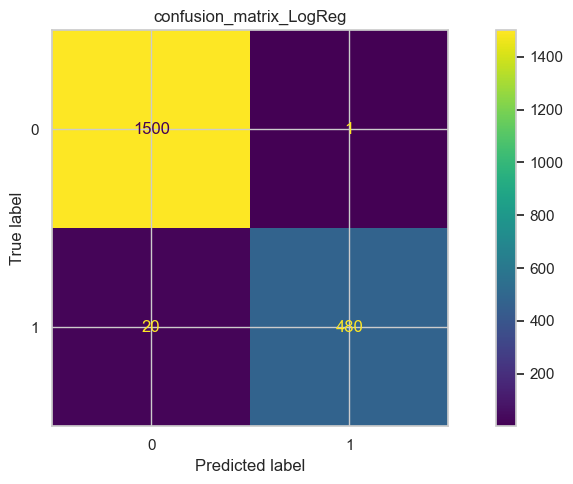

Saved: labstyle_artifacts\figures\roc_LogReg.png


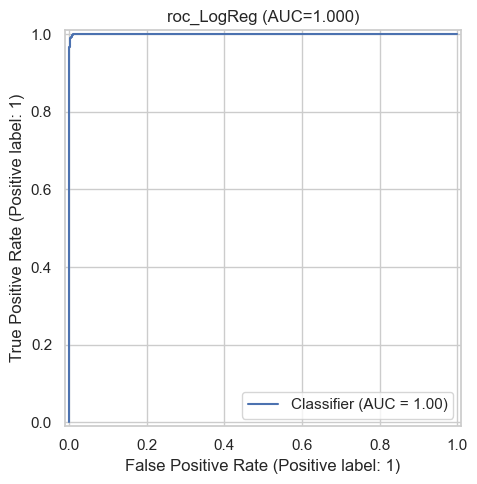


DecisionTree metrics
{'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
Saved: labstyle_artifacts\figures\confusion_matrix_DecisionTree.png


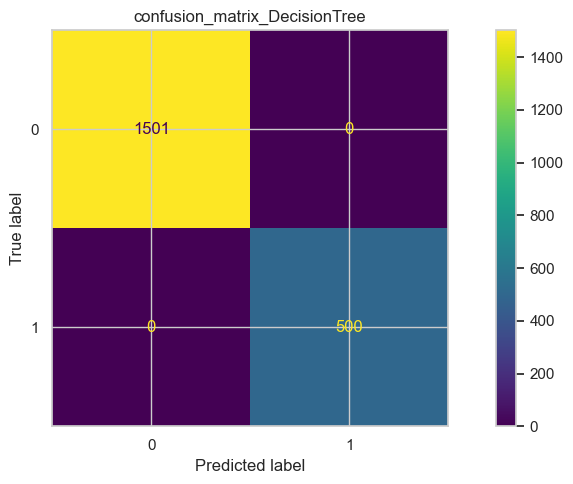

Saved: labstyle_artifacts\figures\roc_DecisionTree.png


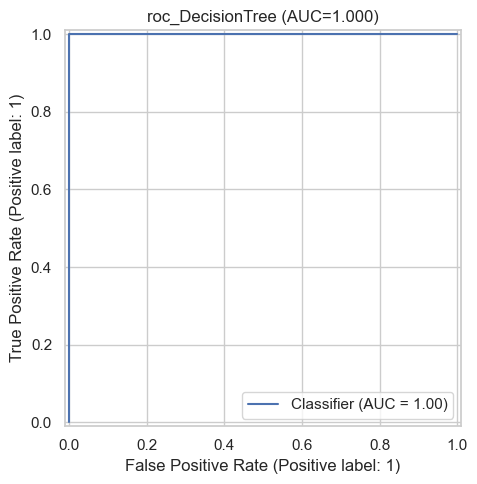


GaussianNB metrics
{'accuracy': 0.5247376311844077, 'precision': 0.2995555555555556, 'recall': 0.674, 'f1': 0.4147692307692308}
Saved: labstyle_artifacts\figures\confusion_matrix_GaussianNB.png


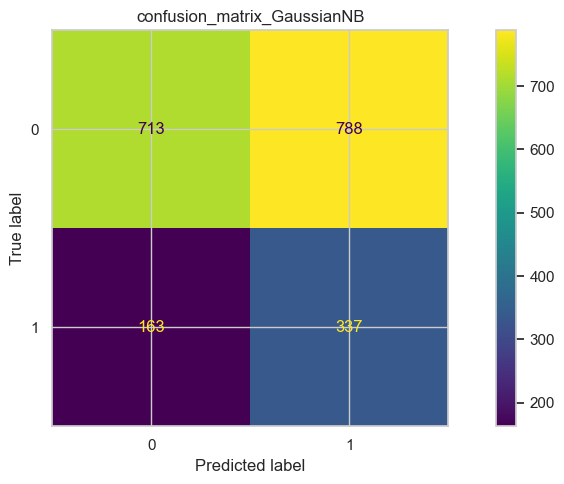

Saved: labstyle_artifacts\figures\roc_GaussianNB.png


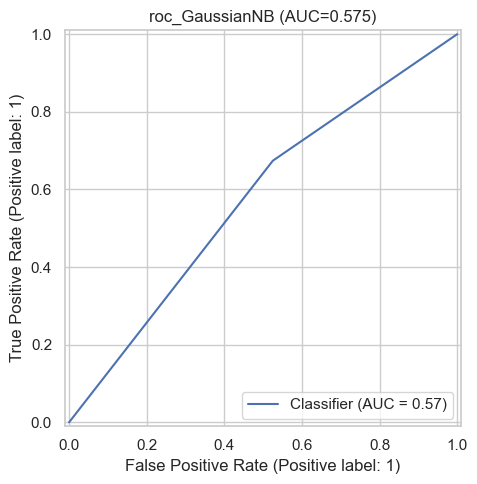


KNN metrics
{'accuracy': 0.936031984007996, 'precision': 0.9744897959183674, 'recall': 0.764, 'f1': 0.8565022421524664}
Saved: labstyle_artifacts\figures\confusion_matrix_KNN.png


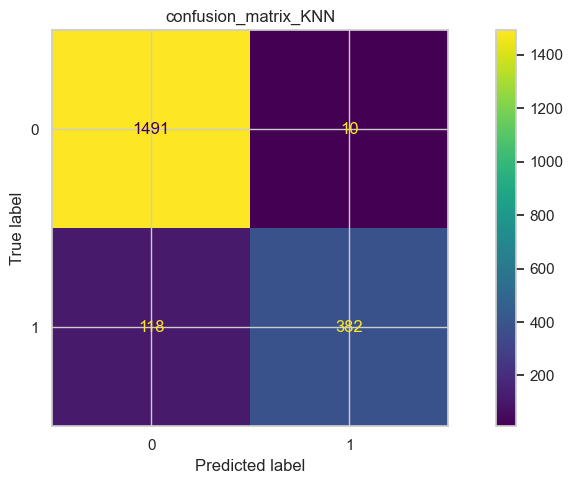

Saved: labstyle_artifacts\figures\roc_KNN.png


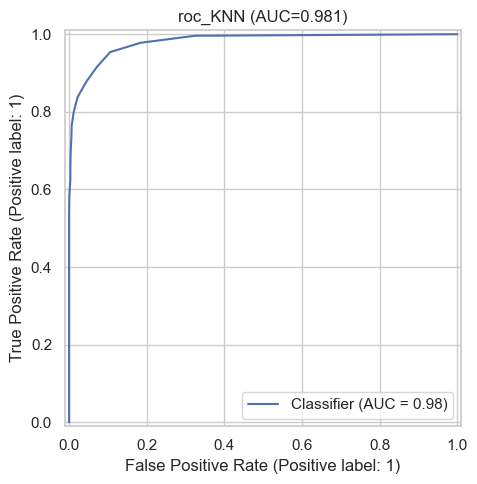


Model comparison:


,model,accuracy,precision,recall,f1,roc_auc
1,DecisionTree,1.000000,1.000000,1.000,1.000000,1.000000
0,LogReg,0.989505,0.997921,0.960,0.978593,0.999875
3,KNN,0.936032,0.974490,0.764,0.856502,0.980654
2,GaussianNB,0.524738,0.299556,0.674,0.414769,0.574508


Saved: labstyle_artifacts\tables\classification_model_comparison.csv
Saved: labstyle_artifacts\figures\bar_classification_f1_comparison.png


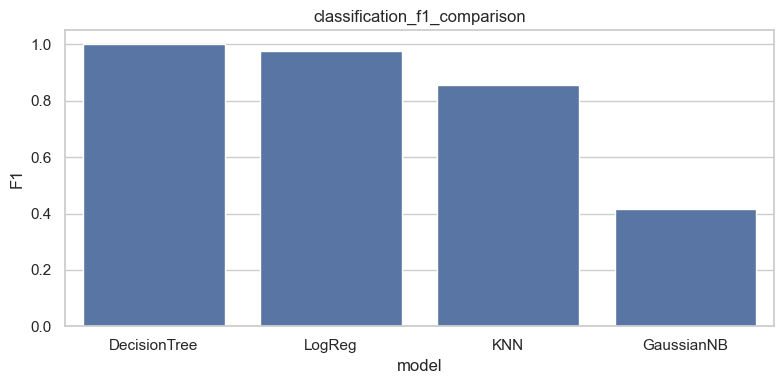

In [22]:
def evaluate_classifier(name: str, model_pipeline: Pipeline):
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n{name} metrics")
    print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1})

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"confusion_matrix_{name}")
    save_fig(f"confusion_matrix_{name}")
    plt.show()

    # ROC curve (if probabilities available)
    roc_auc = np.nan
    try:
        if hasattr(model_pipeline, "predict_proba"):
            y_proba = model_pipeline.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_proba)
            RocCurveDisplay.from_predictions(y_test, y_proba)
            plt.title(f"roc_{name} (AUC={roc_auc:.3f})")
            save_fig(f"roc_{name}")
            plt.show()
    except Exception as e:
        print(f"ROC skipped for {name}: {e}")

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc,
    }


results = []

# Logistic Regression (sparse OK)
logreg = Pipeline(
    steps=[
        ("preprocess", preprocess_sparse),
        ("model", LogisticRegression(max_iter=2000, solver="saga", random_state=RANDOM_STATE)),
    ]
)
results.append(evaluate_classifier("LogReg", logreg))

# Decision Tree (dense is fine)
dtree = Pipeline(
    steps=[
        ("preprocess", preprocess_dense),
        ("model", DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=None)),
    ]
)
results.append(evaluate_classifier("DecisionTree", dtree))

# Gaussian Naive Bayes (needs dense)
gnb = Pipeline(
    steps=[
        ("preprocess", preprocess_sparse),
        ("to_dense", FunctionTransformer(to_dense)),
        ("model", GaussianNB()),
    ]
)
results.append(evaluate_classifier("GaussianNB", gnb))

# KNN (prefer dense)
knn = Pipeline(
    steps=[
        ("preprocess", preprocess_dense),
        ("model", KNeighborsClassifier(n_neighbors=15)),
    ]
)
results.append(evaluate_classifier("KNN", knn))

results_df = pd.DataFrame(results).sort_values("f1", ascending=False)
print("\nModel comparison:")
display(results_df)

out_path = group_tables_dir / "classification_model_comparison.csv"
results_df.to_csv(out_path, index=False)
print("Saved:", out_path)

plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="model", y="f1")
plt.title("classification_f1_comparison")
plt.xlabel("model")
plt.ylabel("F1")
save_fig("bar_classification_f1_comparison")
plt.show()

## 15) Regression (Linear Regression)

Only **Linear Regression** is used for regression (per requirement).


Regression target: log1p(revenue)
{'MAE': 6.007129930942895, 'RMSE': 7.027874478210523, 'R2': 0.34743958268785846}
Saved: labstyle_artifacts\figures\scatter_predicted_vs_actual_linear_regression.png


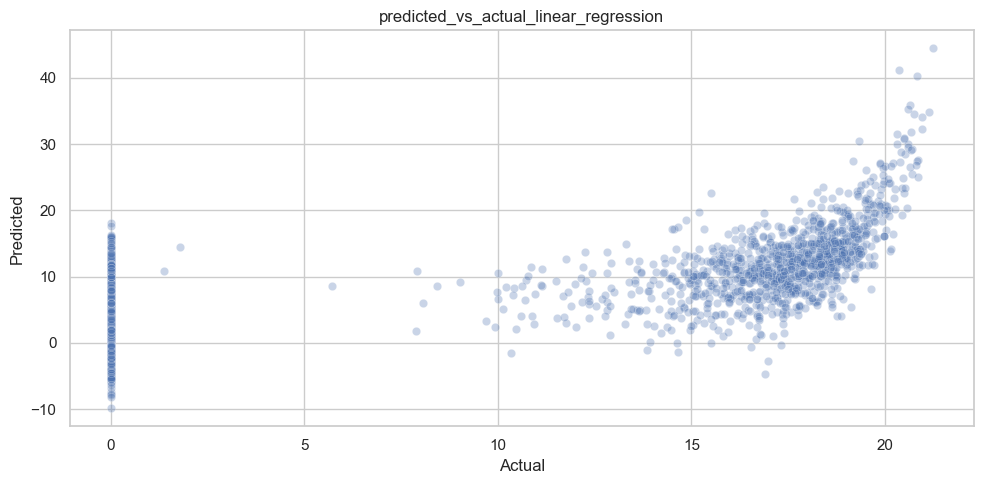

Saved: labstyle_artifacts\tables\linear_regression_metrics.csv


In [24]:
if not regression_available:
    print("Regression section skipped: no suitable regression target found in dataset.")
else:
    reg_df = ml_df.dropna(subset=["reg_target"]).copy()
    Xr = sanitize_for_sklearn(reg_df[feature_cols])
    yr = reg_df["reg_target"].astype(float)

    Xr_train, Xr_test, yr_train, yr_test = train_test_split(
        Xr, yr, test_size=0.2, random_state=RANDOM_STATE
    )

    linreg = Pipeline(
        steps=[
            ("preprocess", preprocess_sparse),
            ("model", LinearRegression()),
        ]
    )

    linreg.fit(Xr_train, yr_train)
    yr_pred = linreg.predict(Xr_test)

    mae = mean_absolute_error(yr_test, yr_pred)
    # Newer sklearn versions removed mean_squared_error(..., squared=False)
    try:
        from sklearn.metrics import root_mean_squared_error

        rmse = root_mean_squared_error(yr_test, yr_pred)
    except Exception:
        rmse = float(np.sqrt(mean_squared_error(yr_test, yr_pred)))

    r2 = r2_score(yr_test, yr_pred)

    print("Regression target:", reg_target_name)
    print({"MAE": mae, "RMSE": rmse, "R2": r2})

    # Predicted vs actual
    plt.figure()
    sns.scatterplot(x=yr_test, y=yr_pred, alpha=0.3)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("predicted_vs_actual_linear_regression")
    save_fig("scatter_predicted_vs_actual_linear_regression")
    plt.show()

    # Save metrics
    reg_metrics = pd.DataFrame([
        {"target": reg_target_name, "MAE": mae, "RMSE": rmse, "R2": r2}
    ])
    out_path = group_tables_dir / "linear_regression_metrics.csv"
    reg_metrics.to_csv(out_path, index=False)
    print("Saved:", out_path)


## 16) Conclusions / Summary


In [25]:
summary_lines = []
summary_lines.append(f"Rows after cleaning: {len(df_clean):,}")
summary_lines.append(f"Saved figures: {len(FIGURE_PATHS)}")

if col_votes:
    summary_lines.append(f"Classification target: high_engagement from {col_votes} (top quartile)")
else:
    summary_lines.append("Classification target: high_engagement (fallback numeric)")

if regression_available:
    summary_lines.append(f"Regression target: {reg_target_name}")
else:
    summary_lines.append("Regression target: not available")

print("\n".join(f"- {s}" for s in summary_lines))

- Rows after cleaning: 10,002
- Saved figures: 24
- Classification target: high_engagement from vote_count (top quartile)
- Regression target: log1p(revenue)
